# Report for Ratings-Results

In [1]:
import report

report.create_report_files(
    "../keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
    "ratings.xlsx",
    "pairs.xlsx",
)

In [2]:
import pandas as pd

pairs = pd.read_excel("./pairs.xlsx")
pairs

,Unnamed: 0,rotation,model_2,model_1,size,dataset,position,high_detail,n_ratings,id
0,0,"[0.9961567660501535, 0.008693328396189522, 0.0...",splats/mcmc-truck-extended-1.ksplat,splats/default-truck-extended-1.ksplat,extended,truck,"[0.58, 0.0, 0.65]",True,3,5dwojHXzFd2RzJ2ZPNtD
1,1,"[0.9961567660501535, 0.008693328396189522, 0.0...",splats/mcmc-truck-medium-1.ksplat,splats/default-truck-medium-1.ksplat,medium,truck,"[0.58, 0.0, 0.65]",False,3,BGOjoywll3sSUYo2pBwY
2,2,"[0.9961567660501535, 0.008693328396189522, 0.0...",splats/mcmc-truck-low-1.ksplat,splats/default-truck-low-1.ksplat,low,truck,"[0.58, 0.0, 0.65]",False,3,OyhrkDZsWy64SkqfZAY5
3,3,"[0.9961567660501535, 0.008693328396189522, 0.0...",splats/mcmc-truck-high-1.ksplat,splats/default-truck-high-1.ksplat,high,truck,"[0.58, 0.0, 0.65]",True,2,PqpflZDmB5tBiM15v9MQ


In [3]:
ratings = pd.read_excel("./ratings.xlsx")
ratings

,Unnamed: 0,rating_1,user_id,pair_id,rating_2,id
0,0,5,ae868375-47d2-4b8a-995b-66e8e33ebf0a,BGOjoywll3sSUYo2pBwY,5,2nRJa9SKRgUZBHy9Ti9w
1,1,4,ae868375-47d2-4b8a-995b-66e8e33ebf0a,5dwojHXzFd2RzJ2ZPNtD,3,PhbCHezTkzTl3gkwCF5U
2,2,3,d5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48,BGOjoywll3sSUYo2pBwY,4,Wm0PNk31XidAdvgB9iUo
3,3,4,ae868375-47d2-4b8a-995b-66e8e33ebf0a,5dwojHXzFd2RzJ2ZPNtD,4,YShT4GJbXiVYmuGPYfv4
4,4,3,b129d86a-4077-4b49-8494-4942b76bfbb1,OyhrkDZsWy64SkqfZAY5,5,eurKXa2qR74n9sOpw4X0
5,5,3,ae868375-47d2-4b8a-995b-66e8e33ebf0a,PqpflZDmB5tBiM15v9MQ,4,hJMVI1CTbDSS4108H6Qp
6,6,5,ae868375-47d2-4b8a-995b-66e8e33ebf0a,BGOjoywll3sSUYo2pBwY,3,hsCX7T7tqPKrlJp6WCcH
7,7,4,4825af3c-d463-4c5c-ac54-781f3890c126,5dwojHXzFd2RzJ2ZPNtD,4,iAQ9g8XGZ9ik4QY9CUdZ
8,8,4,4825af3c-d463-4c5c-ac54-781f3890c126,OyhrkDZsWy64SkqfZAY5,4,tvllY9jEMZ4FEdMYjpzt
9,9,3,d5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48,PqpflZDmB5tBiM15v9MQ,5,xRRIvdDlH0BG453SGVSz


In [4]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
ratings_count_computed

pair_id
5dwojHXzFd2RzJ2ZPNtD    3
BGOjoywll3sSUYo2pBwY    3
OyhrkDZsWy64SkqfZAY5    3
PqpflZDmB5tBiM15v9MQ    2
Name: id, dtype: int64

In [5]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

There are 4 users


([0, 1, 2, 3],
 [Text(0, 0, 'ae868375-47d2-4b8a-995b-66e8e33ebf0a'),
  Text(1, 0, 'd5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48'),
  Text(2, 0, 'b129d86a-4077-4b49-8494-4942b76bfbb1'),
  Text(3, 0, '4825af3c-d463-4c5c-ac54-781f3890c126')])

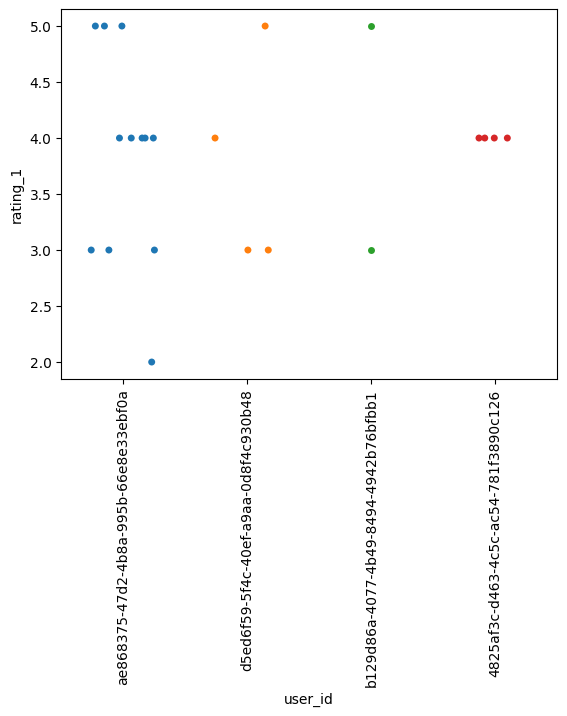

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt 

n_users = len(ratings["user_id"].unique())
print(f"There are {n_users} users")

sns.stripplot(ratings, x="user_id", y="rating_1", jitter=0.3, hue="user_id")
plt.xticks(rotation=90)

sns.stripplot(ratings, x="user_id", y="rating_2", jitter=0.3, hue="user_id")
plt.xticks(rotation=90)

In [23]:
df_ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user

user_id
4825af3c-d463-4c5c-ac54-781f3890c126    2
ae868375-47d2-4b8a-995b-66e8e33ebf0a    6
b129d86a-4077-4b49-8494-4942b76bfbb1    1
d5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48    2
Name: id, dtype: int64

In [7]:
ratings

,Unnamed: 0,rating_1,user_id,pair_id,rating_2,id
0,0,5,ae868375-47d2-4b8a-995b-66e8e33ebf0a,BGOjoywll3sSUYo2pBwY,5,2nRJa9SKRgUZBHy9Ti9w
1,1,4,ae868375-47d2-4b8a-995b-66e8e33ebf0a,5dwojHXzFd2RzJ2ZPNtD,3,PhbCHezTkzTl3gkwCF5U
2,2,3,d5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48,BGOjoywll3sSUYo2pBwY,4,Wm0PNk31XidAdvgB9iUo
3,3,4,ae868375-47d2-4b8a-995b-66e8e33ebf0a,5dwojHXzFd2RzJ2ZPNtD,4,YShT4GJbXiVYmuGPYfv4
4,4,3,b129d86a-4077-4b49-8494-4942b76bfbb1,OyhrkDZsWy64SkqfZAY5,5,eurKXa2qR74n9sOpw4X0
5,5,3,ae868375-47d2-4b8a-995b-66e8e33ebf0a,PqpflZDmB5tBiM15v9MQ,4,hJMVI1CTbDSS4108H6Qp
6,6,5,ae868375-47d2-4b8a-995b-66e8e33ebf0a,BGOjoywll3sSUYo2pBwY,3,hsCX7T7tqPKrlJp6WCcH
7,7,4,4825af3c-d463-4c5c-ac54-781f3890c126,5dwojHXzFd2RzJ2ZPNtD,4,iAQ9g8XGZ9ik4QY9CUdZ
8,8,4,4825af3c-d463-4c5c-ac54-781f3890c126,OyhrkDZsWy64SkqfZAY5,4,tvllY9jEMZ4FEdMYjpzt
9,9,3,d5ed6f59-5f4c-40ef-a9aa-0d8f4c930b48,PqpflZDmB5tBiM15v9MQ,5,xRRIvdDlH0BG453SGVSz
